# 1-dimensional interpolation

These examples are based on [NCL's 1-d interpolationes examples](https://www.ncl.ucar.edu/Applications/interp1d.shtml). For practical purposes, this notebook shows several ways to do simple 1-dimensional interpolation using numpy or SciPy. In particular, in the following we will show how to  use B-spline interpolation from SciPy's `interpolate` module; the process is different than in NCL because it is divided into two steps: first derive the interpolator and second solve it at some set of points. The example also shows how to get the derivative and integral of the interpolated curve, just like in NCL's example.

There is a tangent about the different underlying libraries/algorithms.

There is an example using least-squares polynomial fitting; we also point out an error in the NCL example. In discovering the error, I also include an example using `UnivariateSpline` as an alternative approach.

The last example shows a comparison of all the methods that we used.

There are other interpolators in SciPy, but for these examples, it was not clear to me whether using them would show any useful differences.


In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

In [89]:
#***********************************************
# Following interp1d_1.ncl
#
#************************************************

#---Specify the input data.
xi = [  0.00,   2.00,   5.00,   8.00,  10.00,  13.00,     \
      15.00,  18.00,  21.00,  23.00,  30.00         ]
yi = [  1.00,   0.81,   0.00,  -0.81,  -1.00,  -0.84,     \
      -0.56,   0.04,   0.73,   1.18,   2.0          ]

#---Create the output X coordinate array.
npts = 201
xr = 30.
xo = np.linspace(0.,xr,npts)

#---Require the derivatives at the endpoints to be zero.
# NOTE: these are paramters for underlying FitGrid
# ftsetp("sf1",0)
# ftsetp("sl1", 0.0)
# ftsetp("sln", 0.0)

#---Interpolate.
# ftcurv : Calculates an interpolatory spline through a sequence of functional values.

# INFO: Spline interpolation requires two essential steps: (1) a spline representation of the curve is computed, and (2) the spline is evaluated at the desired points.
#yo = ftcurv(xi, yi, xo)
tck = interpolate.splrep(xi, yi, s=0)
yo = interpolate.splev(xo, tck, der=0)
#---Find the derivatives.
# yd = ftcurvd(xi, yi, xo)
yd = interpolate.splev(xo, tck, der=1)

#---Find the integrals starting from x=0.
yint = np.zeros(npts)
for n in range(len(yint)-1):
    yint[n] = interpolate.splint(0, xo[n], tck)


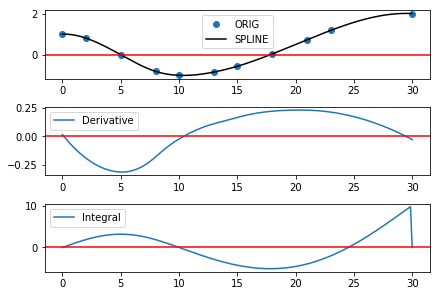

In [90]:
fig, ax = plt.subplots(nrows=3, constrained_layout=True)
ax[0].plot(xi, yi, marker='o', linestyle='none', label='ORIG')
ax[0].plot(xo, yo, color='black', label="SPLINE")
ax[0].axhline(0, color='red')

ax[1].plot(xo, yd, label='Derivative')
ax[1].axhline(0, color='red')

ax[2].plot(xo, yint, label='Integral')
ax[2].axhline(0, color='red')

lgs = [a.legend() for a in ax]


# Underlying Libraries and Algorithms

Now we turn to `interp1d_2.ncl` which changes the tension paramter, `sig` in NCL's `ftcurv`. According to NCL's documentation, this `sig` parameter:

    The value for the parameter sig specifies the tension factor. 
    Values near zero result in a cubic spline; large values (e.g. 50) 
    result in nearly a polygonal line. A typical value is 1. (the default).

NCL uses Fitgrid to do this, and describes the spline as "cubic splines under tension." [Fitgrid](http://www.ncarg.ucar.edu//ngmath/fitgrid/fithome.html) is apparently an old UCAR library. The Fitgrid description notes that the implementation uses a scalar tension factor to smoothy vary from cubic spline to linear spline. It also notes that Fitgrid is based on Alan Cline's Fitpack; I was unable to trace that library beyond a Netlib page that is ambiguous about the state of the package [LINK](https://www.netlib.org/fitpack/). 

SciPy also uses Fitpack, confusingly, it uses a _different_ Fitpack, and even worse, it also seems to be part of Netlib ([Dierckx](http://www.netlib.org/dierckx/)). In the Dierckx package there does not seem to be an obvious way to manipulate the "tension" of the splines. Scipy has functional and object-oriented interfaces to the Dierckx Fitpack routines. In SciPy's `scipy.interpolate.splrep` function, there are two potential ways to try to mimic the `sig` paramter. First, there is:

    k : int, optional
    The degree of the spline fit. It is recommended to use cubic splines. 
    Even values of k should be avoided especially with small s values. 1 <= k <= 5

And then there `s`, which I think is more directly analogous:

    s : float, optional
    A smoothing condition. 
    The amount of smoothness is determined by satisfying the conditions: 
        sum((w * (y - g))**2,axis=0) <= s 
    where g(x) is the smoothed interpolation of (x,y). The user can use s to 
    control the tradeoff between closeness and smoothness of fit. Larger s means 
    more smoothing while smaller values of s indicate less smoothing. Recommended
    values of s depend on the weights, w. If the weights represent the inverse of
    the standard-deviation of y, then a good s value should be found in the range
    (m-sqrt(2*m),m+sqrt(2*m)) where m is the number of datapoints in x, y, and w. 
    default : s=m-sqrt(2*m) if weights are supplied. 
    s = 0.0 (interpolating) if no weights are supplied.

As will be shown, these are not very good analogies. I think (without diving into the code further) that NCL's `sig` only goes between linear and cubic splines (not sure where it becomes equal to quadratic, if it does).

In [91]:
import xarray as xr

In [92]:
ni = 36             # # of input points
no = 60             # # of output points
xi = np.arange(1,ni+1,1)  # Input X array
xo = np.linspace(1,ni,no) # Output X array, same range as input X array

#--Open NetCDF file and read data to be interpolated
# f  = addfile ("TestData.xy3.nc" , "r")
f = xr.open_dataset("/Users/brianpm/Documents/www.ncl.ucar.edu/Applications/Data/cdf/TestData.xy3.nc")
yi = f['T'][0,0:ni]   # Input Y array

#---Create smoothed array using different smoothing factors
sigs = [1.,5.,10.,20.,30.,40.]
nsigs = len(sigs)

print(f"The size of xi is {xi.shape} and the size of yi is {yi.shape}")

#---Apply different tension factors
yo = np.zeros((nsigs,no), dtype=float)
for i, sig_val in enumerate(sigs):
#     ftsetp("sig",sigs(i))
#     yo(i,:) = ftcurv(xi, yi, xo)
    tck = interpolate.splrep(xi, yi, s=sig_val)
    yo[i,:] = interpolate.splev(xo, tck, der=0)




The size of xi is (36,) and the size of yi is (36,)


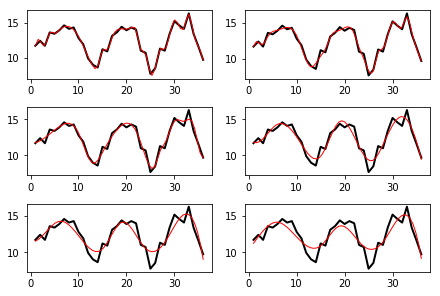

In [93]:
fig, ax = plt.subplots(nrows=3, ncols=2, constrained_layout=True)
for i, a in enumerate(ax.ravel()):
    a.plot(xi, yi, linewidth=2, color='black')
    a.plot(xo, yo[i,:], linewidth=1, color='red', label=sigs[i])


So the result looks very different from NCL because as we increase `s` we get a smoother and smoother curve, whereas in NCL the fit becomes more and more "polygonal" (??). Let's reapeat, but decreasing `s` to decrease the smoothing.

The size of xi is (36,) and the size of yi is (36,)


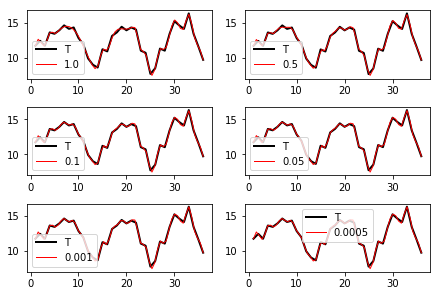

In [94]:
#---Create smoothed array using different smoothing factors
sigs = [1.,0.5, 0.1, 0.05, 0.001, 0.0005]
nsigs = len(sigs)

print(f"The size of xi is {xi.shape} and the size of yi is {yi.shape}")

#---Apply different tension factors
yo = np.zeros((nsigs,no), dtype=float)
for i, sig_val in enumerate(sigs):
#     ftsetp("sig",sigs(i))
#     yo(i,:) = ftcurv(xi, yi, xo)
    tck = interpolate.splrep(xi, yi, s=sig_val)
    yo[i,:] = interpolate.splev(xo, tck, der=0)


fig, ax = plt.subplots(nrows=3, ncols=2, constrained_layout=True)
for i, a in enumerate(ax.ravel()):
    a.plot(xi, yi, linewidth=2, color='black')
    a.plot(xo, yo[i,:], linewidth=1, color='red', label=sigs[i])
    a.legend()

Decreasing `s` seems to do the job of replicating the NCL `sig` parameter. But just to see it, let's also change the order of the spline, increasing from cubic. It should also show "improved" fit.

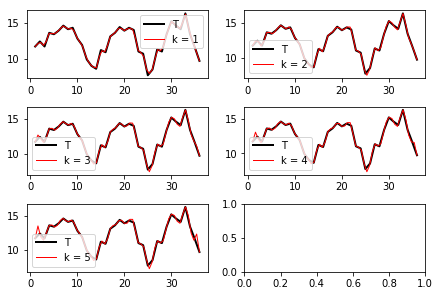

In [95]:
#---Create smoothed array using different smoothing factors
k = [1, 2, 3, 4, 5] # ORDER OF SPLINE (3 is cubic) (only up to 5 is supported)

#---Apply different tension factors
yo = np.zeros((len(k), no), dtype=float)
for i, k_val in enumerate(k):
    tck = interpolate.splrep(xi, yi, k=k_val)
    yo[i,:] = interpolate.splev(xo, tck, der=0)

fig, ax = plt.subplots(nrows=3, ncols=2, constrained_layout=True)
for i, a in enumerate(ax.ravel()):
    if i < len(k):
        a.plot(xi, yi, linewidth=2, color='black')
        a.plot(xo, yo[i,:], linewidth=1, color='red', label=f'k = {k[i]}')
        a.legend()

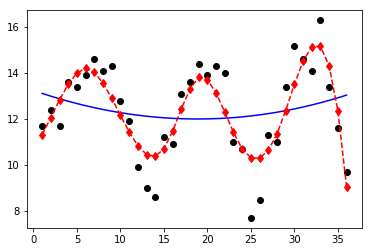

In [96]:
# interp1d_3.ncl
#
# Calculate a set of coefficients for a least-squares 
# polynomial fit. All weights are set to 1.
#
# c  = lspoly(xi, yi, 1, 4)
#                     ^weights
#                        ^ degree of polynomial (including const)
# yo = c(0) + c(1)*yi + c(2)*(yi^2) + c(3)*(yi^3)
c = np.polyfit(xi, yi, 3)  # just coefficients retured; see docs to get SVD info or Covariance matrix
cpoly = np.poly1d(c)

# alternate spline:
c2 = interpolate.UnivariateSpline(xi, yi)  # degree 3 is default


fig, ax = plt.subplots()
ax.plot(xi, yi, 'ok')
ax.plot(xi, cpoly(xi), '-b')
# ax.plot(xi, c[0]*xi**3 + c[1]*xi**2 + c[2]*xi + c[3], '*b')
ax.plot(xi, c2(xi), "dr", linestyle='--')

In [97]:
# looks different than NCL example, so let's compare with the simple example on doc page for lspoly
xExample = [-4.5, -3.2, -1.4, 0.8, 2.5, 4.1]
yExample = [0.7,  2.3,  3.8, 5.0, 5.5, 5.6]

n = 3
cExample = np.polyfit(xExample, yExample, n)
print(cExample)
#The 3rd degree polynomial is
#         Y = c(0) + c(1)*x + c(2)*x^2 + c(3)*x^3
#The coefficients (which agree with those returned from Mathematica) are:
#(0)      4.66863          
#(1)      0.489392        
#(2)     -0.0742387      
#(3)      0.00267663    
# Numpy: Y = c[0]*x**3 + c[1]*x**2 + c[2]*x + c[3]
# We match these with polyfit.

[ 2.67659411e-03 -7.42386664e-02  4.89392494e-01  4.66862641e+00]


Oh. The reason that the NCL line looks very different form the red one above is because they have an error. They used the coefficients and fit to the y values:

    yo = c(0) + c(1)*yi + c(2)*(yi^2) + c(3)*(yi^3)

That is incorrect, those `yi` should all be xi. 
Just to make sure, let's go ahead and replicate that INCORRECT plot.

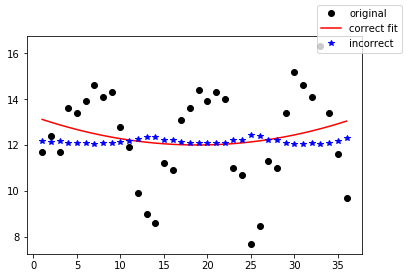

In [98]:

fig, ax = plt.subplots()
ax.plot(xi, yi, 'ok', label='original')
ax.plot(xi, cpoly(xi), '-r', label='correct fit')
ax.plot(xi, c[0]*yi**3 + c[1]*yi**2 + c[2]*yi + c[3], '*b', label='incorrect')
fig.legend()

In [99]:
# interp1d_4.ncl
# Compare 3 different interpolation methods
# - linear 
# - cubic spline under tension
# - "csa1" : Calculates an approximating cubic spline for the input data, one 1-dimensional section at a time.

# Since I don't really understand the difference between Fitpack and Csagrid, both using "cubic spline",
# I will instead show
# - linear
# - least-squares polynomia
# - B-spline (cubic)
# - Univariate spline


#---Specify the input X and Y arrays
xi = [0.00,  2.00,  5.00,  8.00, 10.00, 13.00,     \
          15.00, 18.00, 21.00, 23.00, 30.00]
yi = [1.00,  0.81,  0.00, -0.81, -1.00, -0.84,     \
          -0.56,  0.04,  0.73,  1.18,  2.0  ]

#---Create the output X coordinate array.
nxo = 30
xo = np.linspace(0.,30.,nxo)
 
# Interpolate from a few points to more points, using three functions 

yo_linear = np.interp(xo, xi, yi)
coefs_lsq = np.polyfit(xi, yi, 3)

f_lsq = np.poly1d(coefs_lsq)
yo_lsq = f_lsq(xo)

tck = interpolate.splrep(xi, yi, s=0)
yo_bspline = interpolate.splev(xo, tck, der=0)

altspline = interpolate.UnivariateSpline(xi, yi)  # degree 3 is default
yo_spline2 = altspline(xo)


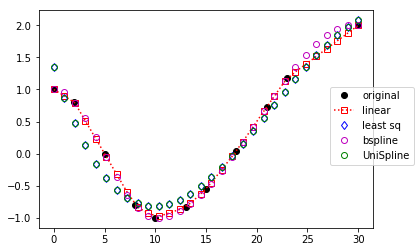

In [100]:
fig, ax = plt.subplots()
ax.plot(xi, yi, 'ok', label='original')
ax.plot(xo, yo_linear, ':rs', label='linear', fillstyle='none')
ax.plot(xo, yo_lsq, 'bd', label="least sq", fillstyle='none')
ax.plot(xo, yo_bspline, 'mo', label='bspline', fillstyle='none')
ax.plot(xo, yo_spline2, 'go', label='UniSpline', fillstyle='none')
fig.legend(loc='center right')
# The Univariate spline and the least squares (green & blue) are indistinguishable,
# and show the largest error.
# The B-spline has larger values at x > 25
# while the linear interpolation has the smallest values around x = 27ish.